# Training ResNet18 in MONAI
This notebook demnstrate how to use monai to train resnet18 on mednist. The dataset contains images of body parts in different modalities including Xrays, CT and MRI. The dataset is loaded from monai-apps using dataloader from monai-data. preprocessing is done using transform with compose and model training is carried-out using supervised trainer. 

### 1. Importing packages

In [1]:
import torch
from monai.transforms import (
    Compose,
    LoadImageD,
    EnsureChannelFirstD,
    ScaleIntensityD,
    RandFlipd,
    RandZoomD,
)
from monai.data import DataLoader, CacheDataset
from monai.networks.nets import resnet18
from monai.apps import MedNISTDataset
from monai.engines import SupervisedTrainer
from monai.networks import eval_mode
from monai.inferers import SimpleInferer
from monai.handlers import StatsHandler, ValidationHandler
from monai.handlers import TensorBoardStatsHandler

import logging
from pathlib import Path
import numpy as np
import sys
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

### 2. Loading the dataset
Define a set of transformations we want to carryout on a dictionary type dataset. Then we used the dataloader to load train and validation splits.

In [3]:
# selected preprocessing
transform = Compose(
    [
        LoadImageD(keys="image", image_only=True), 
        EnsureChannelFirstD(keys="image"),
        ScaleIntensityD(keys="image"), # pixel normalization
        RandFlipd(keys="image", prob=0.5, spatial_axis=0), # random flip
        RandZoomD(keys="image", min_zoom=0.9, max_zoom=1.1, prob=0.5),  # random zoom/crop
    ]
)

In [ ]:
root_dir = "./data" #define root directory for dataset
batch = 512 # define batch size
#workers = 16    # define number of workers for dataloader. can be slow on some platforms. can counter with cache dataset and list

dataset = MedNISTDataset(root_dir=root_dir, 
                         transform=transform, 
                         section="training", 
                         download=True)

train_loader = DataLoader(dataset, 
                          batch_size=batch, 
                          shuffle=True,)

# Create validation dataset and loader
val_dataset = MedNISTDataset(root_dir=root_dir, 
                              transform=transform, 
                              section="validation",)

val_loader = DataLoader(val_dataset, 
                        batch_size=batch, 
                        shuffle=False, )

2025-10-15 10:10:41,784 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2025-10-15 10:10:41,785 - INFO - File exists: data\MedNIST.tar.gz, skipped downloading.
2025-10-15 10:10:41,786 - INFO - Non-empty folder exists in data\MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 5895/5895 [00:03<00:00, 1705.85it/s]


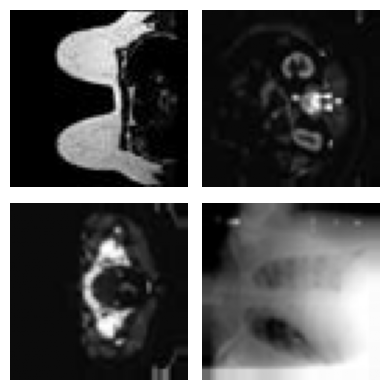

In [ ]:
# Show 4 sample images from the train data loader
sample_batch = next(iter(train_loader))
images = sample_batch["image"][:4].cpu().numpy() # 4 samples from batch

plt.figure(figsize=(4, 4))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.tight_layout()

### 3. Training ResNet18

In [6]:
torch.cuda.is_available() # check if GPU is available

True

In [7]:
max_epochs = 10
model = resnet18(spatial_dims=2, # 2d-image model 
                 n_input_channels=1, # grey-scale images
                 num_classes=6).to("cuda:0") # 6 classes in mednist

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
trainer = SupervisedTrainer(
    device=torch.device("cuda:0"), # device on which to train the model
    max_epochs=max_epochs,
    train_data_loader=train_loader, # training dataloader
    network=model, # resnet18 model to be trained
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-5), # Adam optimizer with learning rate 1e-5
    loss_function=torch.nn.CrossEntropyLoss(), # cross-entropy loss for multi-class classification
    inferer=SimpleInferer(),    # default inferer i.e all image pixels are used to generate output because image can fit in gpu memory
    train_handlers=[
        StatsHandler(),
        TensorBoardStatsHandler(log_dir="./tensorboard_runs"),  # TensorBoard log directory optional argument
    ], # training handlers for stats and tensorboard
)

In [8]:
trainer.run()

INFO:ignite.engine.engine.SupervisedTrainer:Engine run resuming from iteration 0, epoch 0 until 10 epochs
2025-10-15 10:11:15,060 - INFO - Epoch: 1/10, Iter: 1/93 -- label: 1.0000 loss: 1.9106 


ignoring non-scalar output in StatsHandler, make sure `output_transform(engine.state.output)` returns a scalar or dictionary of key and scalar pairs to avoid this warning. image:<class 'monai.data.meta_tensor.MetaTensor'>
ignoring non-scalar output in StatsHandler, make sure `output_transform(engine.state.output)` returns a scalar or dictionary of key and scalar pairs to avoid this warning. pred:<class 'monai.data.meta_tensor.MetaTensor'>
ignoring non-scalar output in TensorBoardStatsHandler, make sure `output_transform(engine.state.output)` returns a scalar or dictionary of key and scalar pairs to avoid this warning. image:<class 'monai.data.meta_tensor.MetaTensor'>
ignoring non-scalar output in TensorBoardStatsHandler, make sure `output_transform(engine.state.output)` returns a scalar or dictionary of key and scalar pairs to avoid this warning. pred:<class 'monai.data.meta_tensor.MetaTensor'>


2025-10-15 10:11:15,747 - INFO - Epoch: 1/10, Iter: 2/93 -- label: 5.0000 loss: 1.8053 
2025-10-15 10:11:16,425 - INFO - Epoch: 1/10, Iter: 3/93 -- label: 0.0000 loss: 1.7916 
2025-10-15 10:11:17,424 - INFO - Epoch: 1/10, Iter: 4/93 -- label: 1.0000 loss: 1.7491 
2025-10-15 10:11:18,132 - INFO - Epoch: 1/10, Iter: 5/93 -- label: 4.0000 loss: 1.7195 
2025-10-15 10:11:18,819 - INFO - Epoch: 1/10, Iter: 6/93 -- label: 4.0000 loss: 1.6782 
2025-10-15 10:11:19,521 - INFO - Epoch: 1/10, Iter: 7/93 -- label: 1.0000 loss: 1.6235 
2025-10-15 10:11:20,207 - INFO - Epoch: 1/10, Iter: 8/93 -- label: 3.0000 loss: 1.6387 
2025-10-15 10:11:20,916 - INFO - Epoch: 1/10, Iter: 9/93 -- label: 5.0000 loss: 1.5869 
2025-10-15 10:11:21,610 - INFO - Epoch: 1/10, Iter: 10/93 -- label: 4.0000 loss: 1.5285 
2025-10-15 10:11:22,327 - INFO - Epoch: 1/10, Iter: 11/93 -- label: 0.0000 loss: 1.4997 
2025-10-15 10:11:23,037 - INFO - Epoch: 1/10, Iter: 12/93 -- label: 3.0000 loss: 1.4940 
2025-10-15 10:11:23,716 - INF

### 4. Run Inference

In [9]:
"""
     Evaluate the model on the test dataset

"""

dataset_dir = Path(root_dir, "MedNIST")
class_names = sorted(f"{x.name}" for x in dataset_dir.iterdir() if x.is_dir())
testdata = MedNISTDataset(root_dir=root_dir, transform=transform, section="test", download=False, runtime_cache=True)

max_items_to_print = 5
with eval_mode(model):
    for item in DataLoader(testdata, batch_size=1, num_workers=0):
        prob = np.array(model(item["image"].to("cuda:0")).detach().to("cpu"))[0] # model prediction probabilities for all classes
        pred = class_names[prob.argmax()] # predicted class or class with max probability
        gt = item["class_name"][0] # ground-truth class
        print(f"Class prediction is {pred}. Ground-truth: {gt}")
        max_items_to_print -= 1
        if max_items_to_print == 0:
            break

Class prediction is AbdomenCT. Ground-truth: AbdomenCT
Class prediction is BreastMRI. Ground-truth: BreastMRI
Class prediction is ChestCT. Ground-truth: ChestCT
Class prediction is CXR. Ground-truth: CXR
Class prediction is Hand. Ground-truth: Hand


### 4 .Train with validation set (Optional)
This is a demo to show how training can be done using a validation set.

In [ ]:
from monai.engines import SupervisedEvaluator

max_epochs = 3
model = resnet18(spatial_dims=2, 
                 n_input_channels=1, 
                 num_classes=6).to("cuda:0") 

# Create evaluator for validation
evaluator = SupervisedEvaluator(
    device=torch.device("cuda:0"),
    val_data_loader=val_loader,
    network=model,
    inferer=SimpleInferer(),
    postprocessing=None,
    key_val_metric=None,
    val_handlers=[StatsHandler()],
)

trainer = SupervisedTrainer(
    device=torch.device("cuda:0"),
    max_epochs=max_epochs,
    train_data_loader=DataLoader(dataset, batch_size=batch, shuffle=True),
    network=model,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-5),
    loss_function=torch.nn.CrossEntropyLoss(),
    inferer=SimpleInferer(),
    train_handlers=[StatsHandler(), ValidationHandler(validator=evaluator, interval=1, epoch_level=True)],
)

In [11]:
trainer.run()

INFO:ignite.engine.engine.SupervisedTrainer:Engine run resuming from iteration 0, epoch 0 until 3 epochs
2025-10-15 10:26:48,774 - INFO - Epoch: 1/3, Iter: 1/93 -- label: 5.0000 loss: 1.8921 


ignoring non-scalar output in StatsHandler, make sure `output_transform(engine.state.output)` returns a scalar or dictionary of key and scalar pairs to avoid this warning. image:<class 'monai.data.meta_tensor.MetaTensor'>
ignoring non-scalar output in StatsHandler, make sure `output_transform(engine.state.output)` returns a scalar or dictionary of key and scalar pairs to avoid this warning. pred:<class 'monai.data.meta_tensor.MetaTensor'>


2025-10-15 10:26:48,973 - INFO - Epoch: 1/3, Iter: 2/93 -- label: 3.0000 loss: 1.8045 
2025-10-15 10:26:49,170 - INFO - Epoch: 1/3, Iter: 3/93 -- label: 3.0000 loss: 1.8105 
2025-10-15 10:26:49,631 - INFO - Epoch: 1/3, Iter: 4/93 -- label: 4.0000 loss: 1.7697 
2025-10-15 10:26:49,822 - INFO - Epoch: 1/3, Iter: 5/93 -- label: 2.0000 loss: 1.7707 
2025-10-15 10:26:50,016 - INFO - Epoch: 1/3, Iter: 6/93 -- label: 3.0000 loss: 1.6574 
2025-10-15 10:26:50,210 - INFO - Epoch: 1/3, Iter: 7/93 -- label: 2.0000 loss: 1.6595 
2025-10-15 10:26:50,401 - INFO - Epoch: 1/3, Iter: 8/93 -- label: 4.0000 loss: 1.6135 
2025-10-15 10:26:50,614 - INFO - Epoch: 1/3, Iter: 9/93 -- label: 3.0000 loss: 1.5953 
2025-10-15 10:26:50,812 - INFO - Epoch: 1/3, Iter: 10/93 -- label: 5.0000 loss: 1.5740 
2025-10-15 10:26:51,002 - INFO - Epoch: 1/3, Iter: 11/93 -- label: 5.0000 loss: 1.5274 
2025-10-15 10:26:51,197 - INFO - Epoch: 1/3, Iter: 12/93 -- label: 3.0000 loss: 1.5230 
2025-10-15 10:26:51,397 - INFO - Epoch: 

## 5. PyTorch Native (Optional)

In [16]:
""" 
    PyTorch Native Training Loop  with TensorBoard Logging  and Validation
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# ----------- Configurations -----------
root_dir = "./data"
batch_size = 512
num_classes = 6
max_epochs = 3
log_dir = "./tensorboard_runs"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------- Model Setup -----------
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter(log_dir=log_dir)

# ----------- Training Loop -----------
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{max_epochs}]")
    # train_loader yields dictionary batches (MONAI dataset), not (inputs, labels)
    for batch in loop:
        inputs = batch["image"]
        labels = batch["label"]

        # move to device and ensure proper shapes/dtypes
        inputs = inputs.to(device)
        labels = labels.long().squeeze().to(device)

        # If model expects 3-channel input but data is single-channel, replicate channels
        if inputs.dim() == 4 and inputs.size(1) == 1 and hasattr(model, "conv1") and getattr(model.conv1, "in_channels", None) == 3:
            inputs = inputs.repeat(1, 3, 1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100. * correct / total
    writer.add_scalar("Loss/train", epoch_loss, epoch)
    writer.add_scalar("Accuracy/train", epoch_acc, epoch)

    # ----------- Validation Loop -----------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_batch in val_loader:
            val_inputs = val_batch["image"]
            val_labels = val_batch["label"]

            val_inputs = val_inputs.to(device)
            val_labels = val_labels.long().squeeze().to(device)

            if val_inputs.dim() == 4 and val_inputs.size(1) == 1 and hasattr(model, "conv1") and getattr(model.conv1, "in_channels", None) == 3:
                val_inputs = val_inputs.repeat(1, 3, 1, 1)

            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)

            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = 100. * val_correct / val_total
    writer.add_scalar("Loss/val", epoch_val_loss, epoch)
    writer.add_scalar("Accuracy/val", epoch_val_acc, epoch)
    print(f"Validation Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.2f}%")

# ----------- Save Model -----------
# torch.save(model.state_dict(), "resnet18_mednist.pth")
writer.close()


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
Epoch [1/3]: 100%|██████████| 93/93 [00:57<00:00,  1.62it/s, acc=78, loss=0.128]  


Validation Loss: 0.3078, Accuracy: 91.57%


Epoch [2/3]: 100%|██████████| 93/93 [00:58<00:00,  1.60it/s, acc=97.9, loss=0.0451]


Validation Loss: 0.2855, Accuracy: 89.82%


Epoch [3/3]: 100%|██████████| 93/93 [00:58<00:00,  1.60it/s, acc=99.3, loss=0.0141]


Validation Loss: 0.3168, Accuracy: 89.45%


## 6. Custom Transform (Optional)

In [ ]:

from monai.transforms import MapTransform
import numpy as np
import torch

class NormalizeAndAddNoiseD(MapTransform):
    """
    Dictionary-based transform that adds Gaussian noise to the specified keys, this case image.
    Works with numpy arrays and torch tensors.
    """
    def __init__(self, keys, mean=0.0, std=0.1, prob=1.0):
        super().__init__(keys)
        self.mean = mean
        self.std = std
        self.prob = prob

    def __call__(self, data):
        d = dict(data)
        # apply noise per-key 
        for key in self.keys:
            if np.random.rand() > self.prob:
                continue
        
            x = d[key]
            
            """
                checking for data type and applying noise accordingly.
                just a fallback mechanism for different data types in case.
            """
            if isinstance(x, np.ndarray):
                noise = np.random.randn(*x.shape).astype(x.dtype) * self.std + self.mean
                
                img = x.astype(np.float32)
                img = (img - img.min()) / (img.max() - img.min())
                d[key] = img + noise

            elif torch.is_tensor(x):
                noise = torch.randn_like(x) * float(self.std) + float(self.mean)
                img = x.astype(np.float32)
                img = (img - img.min()) / (img.max() - img.min())

                d[key] = x + noise
            else:
                # fallback: try to convert to numpy
                try:
                    arr = np.asarray(x)
                    noise = np.random.randn(*arr.shape).astype(arr.dtype) * self.std + self.mean
                    arr = arr.astype(np.float32)
                    img = (arr - arr.min()) / (arr.max() - arr.min())

                    d[key] = img + noise
                except Exception:
                    d[key] = x
        return d

# Example usage in a transform pipeline for MedNIST
mednist_transforms = Compose(
    [
        LoadImageD(keys="image", image_only=True),
        EnsureChannelFirstD(keys="image"),
        ScaleIntensityD(keys="image"),
        RandFlipd(keys="image", prob=0.5, spatial_axis=0),
        RandZoomD(keys="image", min_zoom=0.9, max_zoom=1.1, prob=0.5),
        NormalizeAndAddNoiseD(keys="image", mean=0.0, std=0.05, prob=1.0),  # Add Gaussian noise
    ]
)


In [20]:
batch=512
root_dir = "./data"

# provides dictionary items and expects dictionary-style transforms (LoadImageD, EnsureChannelFirstD, ...)
dataset = MedNISTDataset(root_dir=root_dir, 
                         transform=mednist_transforms, 
                         section="training", 
                         download=True)


2025-10-15 14:26:04,954 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2025-10-15 14:26:04,955 - INFO - File exists: data\MedNIST.tar.gz, skipped downloading.
2025-10-15 14:26:04,956 - INFO - Non-empty folder exists in data\MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 47164/47164 [00:32<00:00, 1449.37it/s]


In [21]:
train_loader = DataLoader(dataset, 
                          batch_size=batch, 
                          shuffle=False, )

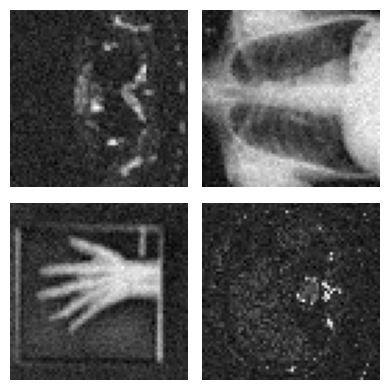

In [22]:
sample_batch = next(iter(train_loader))
images = sample_batch["image"][:5].cpu().numpy()

plt.figure(figsize=(4, 4))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.tight_layout()